In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import argparse
import os
import glob
from pathlib import Path
from tqdm import tqdm
from collections import Counter
import pandas as pd

In [12]:
from transformers import GPT2TokenizerFast
tokenizer = GPT2TokenizerFast.from_pretrained('Xenova/gpt-3.5-turbo')
pad_token = tokenizer.eos_token
tokenizer.pad_token = pad_token

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT3_5Tokenizer'. 
The class this function is called from is 'GPT2TokenizerFast'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [48]:
#Initialize Model
from transformers import GPT2LMHeadModel, GPT2Config, GPT2Tokenizer
config = GPT2Config(vocab_size=tokenizer.vocab_size, n_layer=2, n_positions = 1024)
model = GPT2LMHeadModel(config)
device = "cpu"
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
losses = []
max_len = 1024

In [114]:
verse_count = 10
specified_lines = list(range(0, verse_count))

Note:
For Noelle - bible links = "/kaggle/input/the-bible/ebible/corpus/eng-eng-kjv.txt" and "/kaggle/input/the-bible/ebible/metadata/vref.txt"


For Alex - bible links = "/kaggle/input/ebible/corpus/eng-eng-kjv.txt" and "/kaggle/input/ebible/metadata/vref.txt"

In [115]:
ref_bible = []
line_count_ref = 0
with open("/kaggle/input/ebible/metadata/vref.txt") as ref:
    for line in ref:
        if line_count_ref in specified_lines:
            ref_bible.append(line.strip())
        line_count_ref += 1
            
en_bible = []
line_count_en = 0
with open("/kaggle/input/ebible/corpus/eng-eng-kjv.txt") as en:
    for line in en:
        if line_count_en in specified_lines:
            en_bible.append(line.strip())
        line_count_en += 1

In [116]:
truedata = []
for x in range(len(ref_bible)):
    truedata.append({"ref": ref_bible[x], "verse" : en_bible[x]})
formatted = [f"{x['ref']} {x['verse']}" for x in truedata]

In [117]:
truedata[0]

{'ref': 'GEN 1:1',
 'verse': 'In the beginning God created the heaven and the earth.'}

In [118]:
tokenized = tokenizer(formatted, return_tensors="pt", padding=True, truncation=True, max_length=max_len)

Epoch 0, Loss: 0.5023029208183288
Epoch 1, Loss: 0.4430639997124672
Epoch 2, Loss: 0.4072847723960876
Epoch 3, Loss: 0.3375641584396362
Epoch 4, Loss: 0.3419670030474663
Epoch 5, Loss: 0.3708652928471565
Epoch 6, Loss: 0.285425628721714
Epoch 7, Loss: 0.336621367931366
Epoch 8, Loss: 0.3791815549135208
Epoch 9, Loss: 0.39353188425302504
Epoch 10, Loss: 0.4764594048261642
Epoch 11, Loss: 0.41965745091438295
Epoch 12, Loss: 0.4004173755645752
Epoch 13, Loss: 0.39983507841825483
Epoch 14, Loss: 0.37771862745285034
Epoch 15, Loss: 0.3978297933936119
Epoch 16, Loss: 0.4087973654270172
Epoch 17, Loss: 0.38109172880649567
Epoch 18, Loss: 0.38471555560827253
Epoch 19, Loss: 0.3094802975654602
Epoch 20, Loss: 0.3700660452246666
Epoch 21, Loss: 0.4059924930334091
Epoch 22, Loss: 0.3921403758227825
Epoch 23, Loss: 0.5213288187980651
Epoch 24, Loss: 0.5133261740207672
Epoch 25, Loss: 0.5147479444742202
Epoch 26, Loss: 0.455149182677269
Epoch 27, Loss: 0.4565669447183609
Epoch 28, Loss: 0.447397835

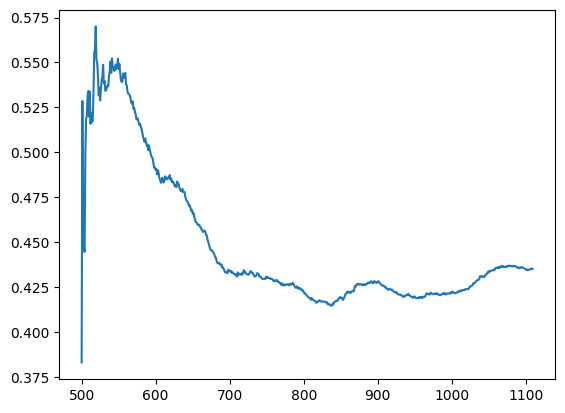

In [119]:
for epoch in range(50):
    sample_counter = 0
    for example in tokenized['input_ids']:
        # Truncate the example to the context length of the model.
        token_ids = example[:max_len]
        input_ids = token_ids[:-1]
        targets = token_ids[1:]

        model_output = model(token_ids[None, :], labels=token_ids)
        loss = model_output.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
        sample_counter += 1
    avg_loss_this_epoch = sum(losses[-sample_counter:]) / sample_counter
    print(f"Epoch {epoch}, Loss: {avg_loss_this_epoch}")

# Plot a smoothed version of the loss (easier to see the trend)
pd.Series(losses)[500:].ewm(alpha = .001).mean().plot();

In [120]:
inputs = tokenizer('GEN 1:1', return_tensors="pt", return_attention_mask=False)
outputs = model.generate(**inputs, max_length=150, do_sample=True)
text = tokenizer.decode(outputs[0], skip_special_tokens=True)
text

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'GEN 1:1 In good God said, Let the waters under the heaven. land ¶ were the waters, and let it the above and was good: and the heaven so. day.'